In [1]:
import matplotlib

matplotlib.use("Agg")

import argparse
import os
import random
import cv2

import matplotlib.pyplot as plt
import numpy as np
from keras.models import model_from_json
from skimage import exposure, io, transform
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# import the necessary packages
from trafficsignnet import TrafficSignNet

2024-06-27 13:52:28.762230: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-27 13:52:29.080823: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-27 13:52:29.145119: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gustavo/.local/lib/python3.8/site-packages/cv2/../../lib64:
2024-06-27 13:52:29.145138: I 

In [3]:
SHAPE = 64

def load_split(basePath, csvPath):
	# initialize the list of data and labels
	data = []
	labels = []

	# load the contents of the CSV file, remove the first line (since
	# it contains the CSV header), and shuffle the rows (otherwise
	# all examples of a particular class will be in sequential order)
	rows = open(csvPath).read().strip().split("\n")[1:]
	random.shuffle(rows)

	# loop over the rows of the CSV file
	for (i, row) in enumerate(rows):
		# check to see if we should show a status update
		if i > 0 and i % 1000 == 0:
			print("[INFO] processed {} total images".format(i))

		# split the row into components and then grab the class ID
		# and image path
		(label, imagePath) = row.strip().split(",")[-2:]

		# derive the full path to the image file and load it
		imagePath = os.path.sep.join([basePath, imagePath])
		image = io.imread(imagePath)

		# resize the image to be 32x32 pixels, ignoring aspect ratio,
		# and then perform Contrast Limited Adaptive Histogram
		# Equalization (CLAHE)
		image = transform.resize(image, (SHAPE, SHAPE)) 
		image = exposure.equalize_adapthist(image, clip_limit=0.1)
		image = (image * 255).astype('uint8')

		image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

		# update the list of data and labels, respectively
		data.append(image)
		labels.append(int(label))

	# convert the data and labels to NumPy arrays
	data = np.array(data)
	labels = np.array(labels)

	# return a tuple of the data and labels
	return (data, labels)

In [4]:
aug_path = "./augmented_traffic_signs"
test_path = "./my_gtsrb"

# load the label names
labelNames = open("signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]


trainPath = os.path.sep.join([aug_path, "Train_aug.csv"])
testPath = os.path.sep.join([test_path, "Test.csv"])

# load the training and testing data
print("[INFO] loading training and testing data...")
(trainX, trainY) = load_split(aug_path, trainPath)
(testX, testY) = load_split(test_path, testPath)

# scale data to the range of [0, 1]
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

[INFO] loading training and testing data...
[INFO] processed 1000 total images
[INFO] processed 2000 total images
[INFO] processed 3000 total images
[INFO] processed 4000 total images
[INFO] processed 5000 total images
[INFO] processed 6000 total images
[INFO] processed 7000 total images
[INFO] processed 8000 total images
[INFO] processed 9000 total images
[INFO] processed 10000 total images
[INFO] processed 11000 total images
[INFO] processed 12000 total images
[INFO] processed 13000 total images
[INFO] processed 14000 total images
[INFO] processed 15000 total images
[INFO] processed 16000 total images
[INFO] processed 17000 total images
[INFO] processed 18000 total images
[INFO] processed 19000 total images
[INFO] processed 20000 total images
[INFO] processed 21000 total images
[INFO] processed 22000 total images
[INFO] processed 23000 total images
[INFO] processed 24000 total images
[INFO] processed 25000 total images
[INFO] processed 1000 total images
[INFO] processed 2000 total im

In [8]:
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(25177, 64, 64) (25177,)
(3570, 64, 64) (3570,)


In [9]:


# one-hot encode the training and testing labels
numLabels = len(np.unique(trainY))
trainY = to_categorical(trainY, numLabels)
testY = to_categorical(testY, numLabels)

In [10]:
# account for skew in the labeled data
classTotals = trainY.sum(axis=0)
classWeight = classTotals.max() / classTotals

classWeight = {i: classWeight[i] for i in range(len(classWeight))}

In [18]:
NUM_EPOCHS = 20
INIT_LR = 1e-3
BS = 64

# construct the image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.15,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	vertical_flip=False,
	fill_mode="nearest")

loss1, loss2 = 'categorical_crossentropy', 'sparse_categorical_crossentropy'
opt = Adam(lr=INIT_LR, decay=INIT_LR / (NUM_EPOCHS * 0.5))

# initialize the optimizer and model
print("[INFO] compiling models...")

light_model = TrafficSignNet.build2(width=SHAPE, height=SHAPE, depth=1,
	classes=numLabels)

light_model.compile(loss=loss1, optimizer=opt,
	metrics=["accuracy"])

# ----------------------

heavy_model = TrafficSignNet.build(width=SHAPE, height=SHAPE, depth=1,
	classes=numLabels)

heavy_model.compile(loss=loss1, optimizer=opt,
	metrics=["accuracy"])

# ----------------

print("[INFO] Light Model Summary")
light_model.summary()

print("[INFO] Heavy Model Summary")
heavy_model.summary()

[INFO] compiling models...
[INFO] Light Model Summary
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 62, 62, 8)         80        
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 15, 15, 8)        0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 1800)              0         
                                                                 
 dense_16 (Dense)            (None, 11)                19811     
                                                                 
Total params: 19,891
Trainable params: 19,891
Non-trainable params: 0
_________________________________________________________________
[INFO] Heavy Model Summary
Model: "sequential_9"
_____________

/home/gustavo/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 chNormalization)                                                
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 32, 32, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 32, 32, 16)        1168      
                                                                 
 activation_33 (Activation)  (None, 32, 32, 16)        0         
                                                                 
 batch_normalization_29 (Bat  (None, 32, 32, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_27 (Conv2D)          (None, 32, 32, 16)        2320      
                                                                 
 activation_34 (Activation)  (None, 32, 32, 16)        0         
          

In [15]:
trainX = np.expand_dims(trainX, axis=-1)  # Adding channel dimension to training data
testX = np.expand_dims(testX, axis=-1) 

print(trainX.shape)

(25177, 64, 64, 1)


In [16]:
print("[INFO] training light network...")
lH = light_model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=trainX.shape[0] // BS,
	epochs=NUM_EPOCHS,
	class_weight=classWeight,
	verbose=1)

[INFO] training light network...
Epoch 1/25
393/393 [==============================] - 14s 35ms/step - loss: 2.2883 - accuracy: 0.4461 - val_loss: 0.6548 - val_accuracy: 0.8563
Epoch 2/25
393/393 [==============================] - 14s 35ms/step - loss: 1.4519 - accuracy: 0.6512 - val_loss: 0.5040 - val_accuracy: 0.8779
Epoch 3/25
393/393 [==============================] - 13s 33ms/step - loss: 1.2565 - accuracy: 0.6944 - val_loss: 0.3988 - val_accuracy: 0.9078
Epoch 4/25
393/393 [==============================] - 18s 45ms/step - loss: 1.1414 - accuracy: 0.7233 - val_loss: 0.4379 - val_accuracy: 0.8697
Epoch 5/25
393/393 [==============================] - 15s 37ms/step - loss: 1.0923 - accuracy: 0.7368 - val_loss: 0.3687 - val_accuracy: 0.8983
Epoch 6/25
393/393 [==============================] - 13s 34ms/step - loss: 1.0514 - accuracy: 0.7414 - val_loss: 0.3873 - val_accuracy: 0.8849
Epoch 7/25
393/393 [==============================] - 13s 33ms/step - loss: 1.0158 - accuracy: 0.7529 -

In [19]:
print("[INFO] training heavy network...")
hH = heavy_model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=trainX.shape[0] // BS,
	epochs=NUM_EPOCHS,
	class_weight=classWeight,
	verbose=1)

[INFO] training heavy network...
Epoch 1/20
393/393 [==============================] - 30s 74ms/step - loss: 1.8572 - accuracy: 0.5232 - val_loss: 0.4530 - val_accuracy: 0.8779
Epoch 2/20
393/393 [==============================] - 30s 76ms/step - loss: 0.8137 - accuracy: 0.7905 - val_loss: 0.2895 - val_accuracy: 0.8818
Epoch 3/20
393/393 [==============================] - 33s 83ms/step - loss: 0.5396 - accuracy: 0.8654 - val_loss: 0.0961 - val_accuracy: 0.9636
Epoch 4/20
393/393 [==============================] - 32s 82ms/step - loss: 0.4293 - accuracy: 0.8934 - val_loss: 0.1022 - val_accuracy: 0.9664
Epoch 5/20
393/393 [==============================] - 31s 79ms/step - loss: 0.3401 - accuracy: 0.9151 - val_loss: 0.0966 - val_accuracy: 0.9636
Epoch 6/20
393/393 [==============================] - 29s 75ms/step - loss: 0.2852 - accuracy: 0.9307 - val_loss: 0.1480 - val_accuracy: 0.9440
Epoch 7/20
393/393 [==============================] - 33s 84ms/step - loss: 0.2460 - accuracy: 0.9411 -

[INFO] evaluating network...
56/56 [==============================] - 0s 4ms/step
                        precision    recall  f1-score   support

  Speed limit (30km/h)       0.00      0.00      0.00       720
                  Stop       0.14      0.81      0.24       270
              No entry       0.25      0.03      0.05       360
             Road work       0.00      0.00      0.00       480
           Pedestrians       0.00      0.05      0.01        60
     Children crossing       0.00      0.00      0.00       150
     Bicycles crossing       0.00      0.00      0.00        90
 Wild animals crossing       0.07      0.16      0.09       270
            Ahead only       0.03      0.01      0.01       390
            Keep right       0.00      0.00      0.00       690
             Keep left       0.02      0.11      0.03        90

              accuracy                           0.08      3570
             macro avg       0.05      0.11      0.04      3570
          weighted a

/home/gustavo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gustavo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gustavo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


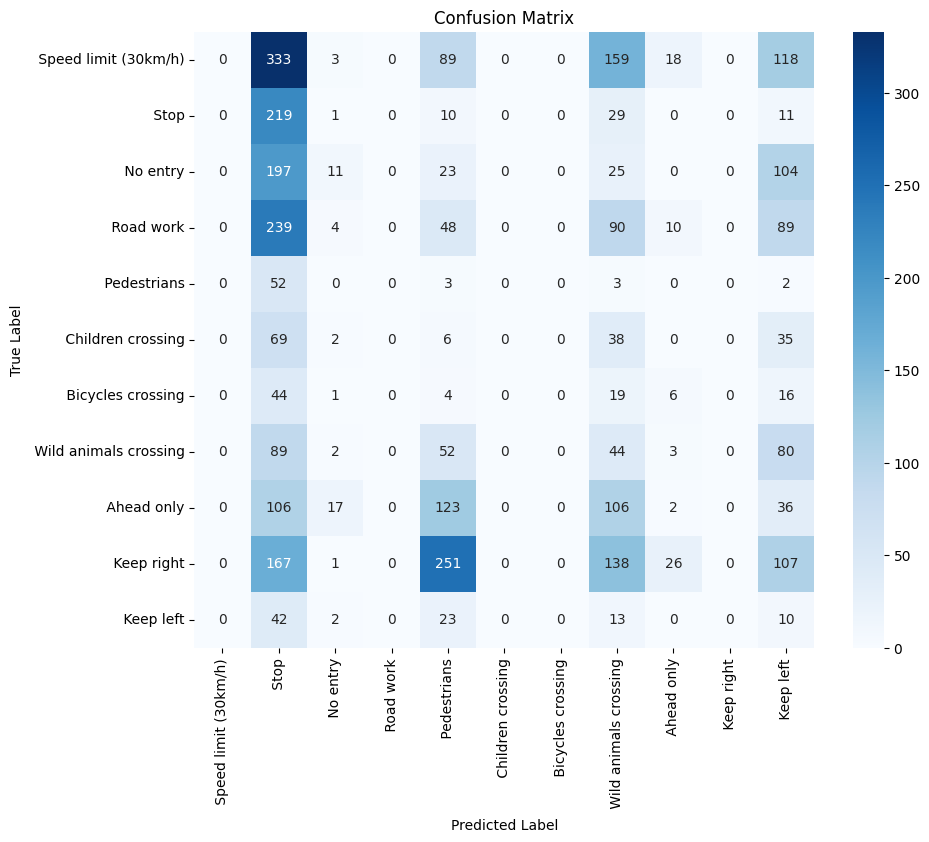

In [22]:
%matplotlib inline

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your model is already trained and test data is prepared

print("[INFO] evaluating network...")
predictions = light_model.predict(testX, batch_size=BS)

# Convert predictions and true labels to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(testY, axis=1)

# Generate the classification report
print(classification_report(true_classes, predicted_classes, target_names=labelNames))

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labelNames, yticklabels=labelNames)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


[INFO] evaluating network...
56/56 [==============================] - 1s 11ms/step
                        precision    recall  f1-score   support

  Speed limit (30km/h)       0.98      1.00      0.99       720
                  Stop       0.99      1.00      0.99       270
              No entry       0.98      0.99      0.99       360
             Road work       0.97      0.99      0.98       480
           Pedestrians       0.96      0.73      0.83        60
     Children crossing       0.99      0.97      0.98       150
     Bicycles crossing       0.93      1.00      0.96        90
 Wild animals crossing       0.98      1.00      0.99       270
            Ahead only       0.99      0.98      0.99       390
            Keep right       1.00      0.90      0.95       690
             Keep left       0.64      0.99      0.78        90

              accuracy                           0.97      3570
             macro avg       0.95      0.96      0.95      3570
          weighted 

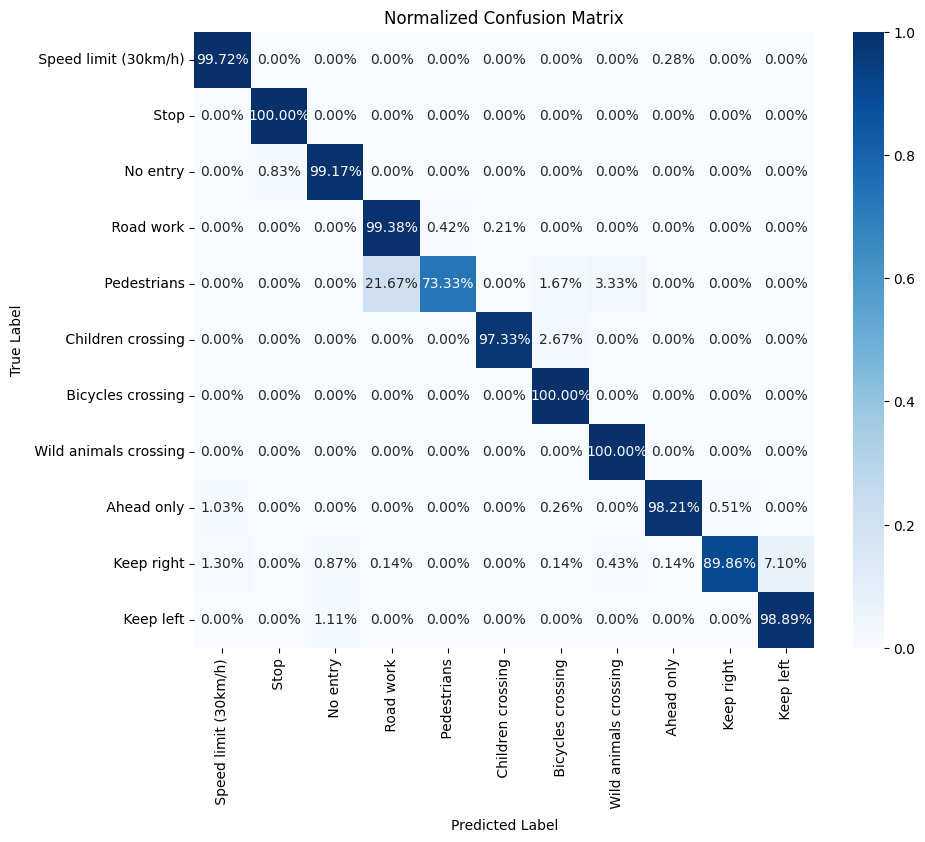

In [24]:
%matplotlib inline

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your model is already trained and test data is prepared

print("[INFO] evaluating network...")
predictions = heavy_model.predict(testX, batch_size=BS)

# Convert predictions and true labels to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(testY, axis=1)

# Generate the classification report
print(classification_report(true_classes, predicted_classes, target_names=labelNames))

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Normalize the confusion matrix by dividing each row by the row sum
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2%", cmap="Blues", xticklabels=labelNames, yticklabels=labelNames)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()

In [25]:
model_path = 'model/trafficsignnet_heavy.model'

# save the network to disk
print("[INFO] serializing network to '{}'...".format(model_path))
heavy_model.save(model_path)


[INFO] serializing network to 'model/trafficsignnet_heavy.model'...


INFO:tensorflow:Assets written to: model/trafficsignnet_heavy.model/assets


INFO:tensorflow:Assets written to: model/trafficsignnet_heavy.model/assets


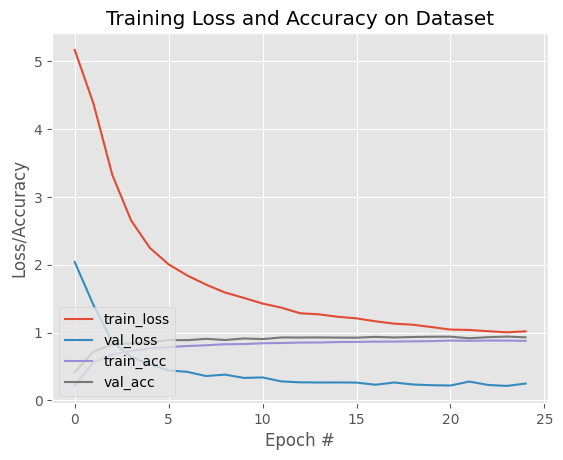

In [27]:


# plot the training loss and accuracy
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("output/plot.png")

In [26]:
import tensorflow as tf

model = tf.keras.models.load_model('./model/trafficsignnet_heavy.model')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model/heavy_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpyu2zvozz/assets


INFO:tensorflow:Assets written to: /tmp/tmpyu2zvozz/assets
2024-06-27 14:43:08.881824: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-06-27 14:43:08.881861: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-06-27 14:43:08.884471: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpyu2zvozz
2024-06-27 14:43:08.892299: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-06-27 14:43:08.892339: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpyu2zvozz
2024-06-27 14:43:08.917950: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2024-06-27 14:43:08.923105: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2024-06-27 14:43:09.040846: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio